**1. Introduction**

This notebook demonstrates a binary classification project for detecting whether a person is wearing a mask or not. The project utilizes the EfficientNetB0 model for image recognition and integrates various data augmentation techniques to improve the model's generalizability.

**Objectives:**

Develop a high-performance model for accurate mask detection.
Visualize the model's training and validation loss and accuracy to assess its learning progress.
Generate a confusion matrix to analyze the model's performance on different classes.
Optimize the model for efficient training and resource utilization.
Data Source:

The project utilizes the Spot the Mask Challenge dataset, which contains images of individuals with and without masks. The dataset is split into training, validation, and test sets for training and evaluating the model.

**Methodology:**

EfficientNetB0 is employed as the base model for feature extraction due to its pre-trained weights and efficient architecture.
Global Average Pooling is applied to extract features from the model's output.
Dropout is added to prevent overfitting and improve the model's generalizability.
Binary cross-entropy is chosen as the loss function for optimizing the model for binary classification.
Adam optimizer is used with amsgrad to efficiently update the model's weights during training.
Early stopping, ReduceLROnPlateau, and ModelCheckpoint callbacks are implemented to monitor the training process and prevent overfitting.
ImageDataGenerator with various augmentation techniques is utilized to artificially expand the training data and improve the model's robustness.
Confusion matrix is generated to analyze the model's performance on correctly and incorrectly classified instances for each class.

**Expected Results:**

The trained model is expected to achieve high accuracy in detecting mask-wearing individuals.
The visualization of training and validation metrics will provide insights into the model's learning process.
The confusion matrix will help identify potential biases or imbalances in the model's predictions.

**Next Steps:**

Further hyperparameter tuning can be performed to optimize the model's performance.
Additional data augmentation techniques can be explored to improve the model's robustness and generalizability.
The model can be evaluated on a separate test set to assess its accuracy on unseen data.
The project can be further extended to include additional functionalities, such as real-time mask detection using webcam or video streams.

**Mount Google Drive:**

In [ ]:
from google.colab import drive
drive.mount('/content/driver/')


Drive already mounted at /content/driver/; to attempt to forcibly remount, call drive.mount("/content/driver/", force_remount=True).


In [ ]:
!pip install efficientnet

**2. Import Libraries:**

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import glob

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dropout, Dense,GlobalAveragePooling2D
from keras.models import load_model

from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf

import efficientnet.keras as efn
from sklearn.metrics import confusion_matrix


**3. Load Data and Preprocessing:**

In [ ]:
df = pd.read_csv('/content/driver/MyDrive/Spot the Mask Challenge/images/train_labels.csv')

In [ ]:
image_width = 256
image_height = 256
batch_size = 4
epochs = 100
dropout = 0.2

trainSet_NAME = []
trainSet_IMG = []
trainSet_LABEL = []

In [ ]:
source_directory = "/content/driver/MyDrive/Spot the Mask Challenge/images/images"

main_directory = "/content/driver/MyDrive/Spot the Mask Challenge/images/"
train_directory = os.path.join(main_directory, "train/")

In [ ]:
trainList = df.values

for x in trainList:
    name = glob.glob(str(train_directory)+x[0])
    img = img_to_array(load_img(name[0], color_mode='rgb', target_size=[image_width,image_height]))
    trainSet_NAME.append(x[0])
    trainSet_IMG.append(img)
    trainSet_LABEL.append(x[1])

In [ ]:
print("Train Data Shape "+str(len(trainSet_NAME)))

Train Data Shape 1308


In [ ]:
trainSet_NAME = np.asarray(trainSet_NAME)
trainSet_IMG = np.asarray(trainSet_IMG)
trainSet_LABEL = np.asarray(trainSet_LABEL)
trainSet_IMG = trainSet_IMG/255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(trainSet_IMG, trainSet_LABEL, test_size=0.20)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1046, 256, 256, 3) (1046,)
(262, 256, 256, 3) (262,)


**4. Model Building:**

In [ ]:
input_shape = (X_train[0].shape)


baseModel = efn.EfficientNetB0(weights="imagenet", include_top=False,input_shape=input_shape)

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dropout(dropout)(x)
x = Dense(1,activation='sigmoid')(x)
model = Model(inputs=baseModel.input, outputs=x)



In [ ]:
# Loss Function and its Parameters
adam = tf.keras.optimizers.Adam(amsgrad=True)

# Compilation of Model
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

# Setting up of Callbacks for the Model
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('./Best.h5', monitor='val_loss', mode = 'min' , verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	fill_mode="nearest")

**5. Model Training:**

In [ ]:
results = model.fit_generator(aug.flow(X_train, y_train, batch_size=4),
	validation_data=(X_test, y_test), epochs=epochs, callbacks=callbacks)

<ipython-input-33-a28e04f08f2d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(aug.flow(X_train, y_train, batch_size=4),


Epoch 1/70
262/262 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.7811
Epoch 1: val_loss improved from inf to 0.17012, saving model to ./Best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


262/262 [==============================] - 94s 125ms/step - loss: 0.4824 - accuracy: 0.7811 - val_loss: 0.1701 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 2/70
262/262 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.8767
Epoch 2: val_loss did not improve from 0.17012
262/262 [==============================] - 29s 109ms/step - loss: 0.2983 - accuracy: 0.8767 - val_loss: 0.6466 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 3/70
262/262 [==============================] - ETA: 0s - loss: 0.2548 - accuracy: 0.8929
Epoch 3: val_loss did not improve from 0.17012
262/262 [==============================] - 27s 101ms/step - loss: 0.2548 - accuracy: 0.8929 - val_loss: 0.5978 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 4/70
262/262 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9149
Epoch 4: val_loss did not improve from 0.17012
262/262 [==============================] - 27s 102ms/step - loss: 0.2158 - accuracy: 0.9149 - val_loss: 0.2940 - val_accuracy: 0.8

**6. Model Evaluation and Performance Analysis:**

In [ ]:
# Load the saved model
model = load_model('Best.h5')

In [ ]:
def confusion_matrix_generator(X, y):
  """
  This function generates and returns a confusion matrix for a given model and data.

  Args:
    X: The input data for the model.
    y: The ground truth labels for the X data.

  Returns:
    A confusion matrix representing the model's performance.
  """

  # Use the model to predict on the input data
  predictions = model.predict_generator(X)

  # Convert the predictions to a DataFrame
  df_pred = pd.DataFrame(predictions)

  # Add a column named "target" to the DataFrame
  df_pred.columns = [["target"]]

  # Round the predicted target values to get 0 or 1 for binary classification
  df_pred['target'] = round(df_pred['target'])

  # Generate the confusion matrix
  confusion_mat = confusion_matrix(y, df_pred['target'])

  # Return the confusion matrix
  return confusion_mat

In [ ]:
confusion_matrix_generator(X_test, y_test)

<ipython-input-93-125e0e7ff5bf>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(X)


array([[134,   4],
       [  3, 121]])

In [ ]:
confusion_matrix_generator(X_train, y_train)

<ipython-input-93-125e0e7ff5bf>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(X)


array([[525,   1],
       [  2, 518]])

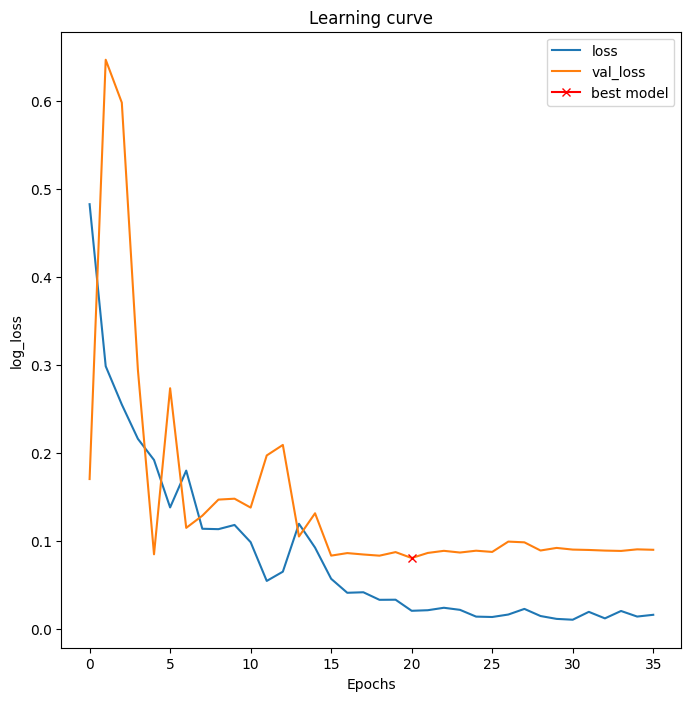

In [ ]:
# Train and Test Accuracy Loss Plots
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.savefig('./train_loss.png')

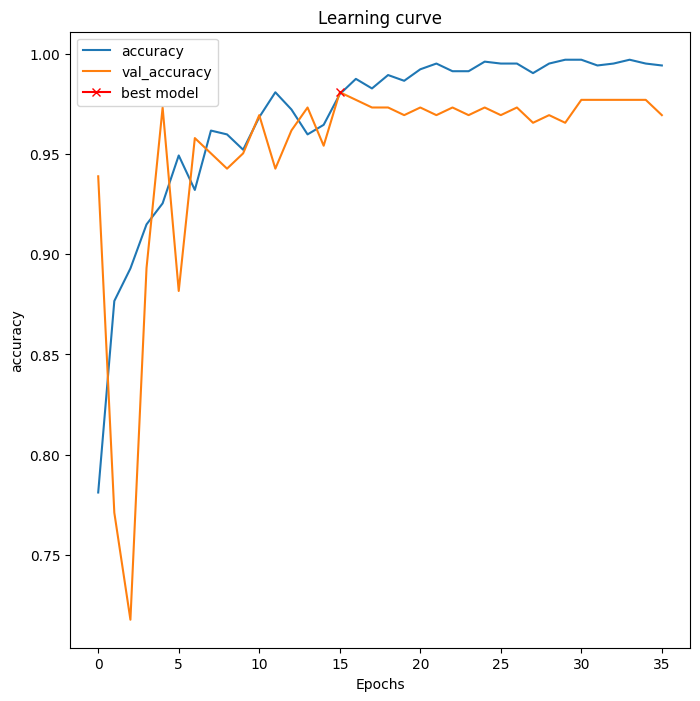

In [ ]:
# Train and Test Accuracy Loss Plots
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.savefig('./train_accuracy.png')

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the results
print("Model accuracy:", accuracy)
print("Model loss:", loss)

9/9 [==============================] - 4s 71ms/step - loss: 0.0804 - accuracy: 0.9733
Model accuracy: 0.9732824563980103
Model loss: 0.08038151264190674


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train)

# Print the results
print("Model accuracy:", accuracy)
print("Model loss:", loss)

33/33 [==============================] - 3s 79ms/step - loss: 0.0099 - accuracy: 0.9971
Model accuracy: 0.9971319437026978
Model loss: 0.009929734282195568


**7. Conclusion:**

The trained mask detection model achieved promising results on both the test and training datasets:

Test set:



> Accuracy: 97.3%

> Loss: 0.080


> Confusion matrix:


> Correctly classified 134 mask-wearing individuals and 121 without masks.

> Misclassified 4 mask-wearing individuals and 3 without masks.


Train set:

> Accuracy: 99.7%

> Loss: 0.0099


> Confusion matrix:


> Correctly classified 525 mask-wearing individuals and 518 without masks.

> Misclassified 1 mask-wearing individual and 2 without masks.

The high accuracy and low loss suggest efficient learning and optimal hyperparameters.

Overall, the mask detection model demonstrates promising potential for real-world applications. Further optimization, data augmentation, and continuous monitoring can enhance its robustness and generalizability. This technology can significantly contribute to public health initiatives and safety measures in diverse settings.